In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
import random

In [2]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(MyImageFolder, self).__getitem__(index)  
        return sample, target, index

In [3]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

normal_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_transform2 = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_ds = MyImageFolder('gaussian_label_data/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('gaussian_label_data/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=get_dataloader_workers())

In [4]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

tensor(1088)
tensor(0)


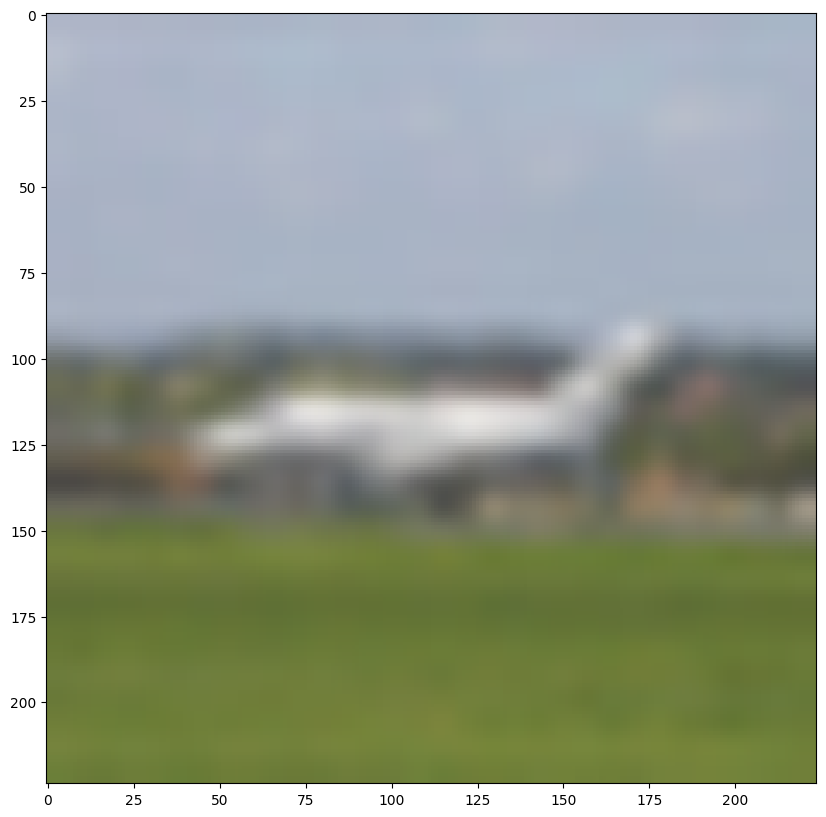

tensor(6569)
tensor(1)


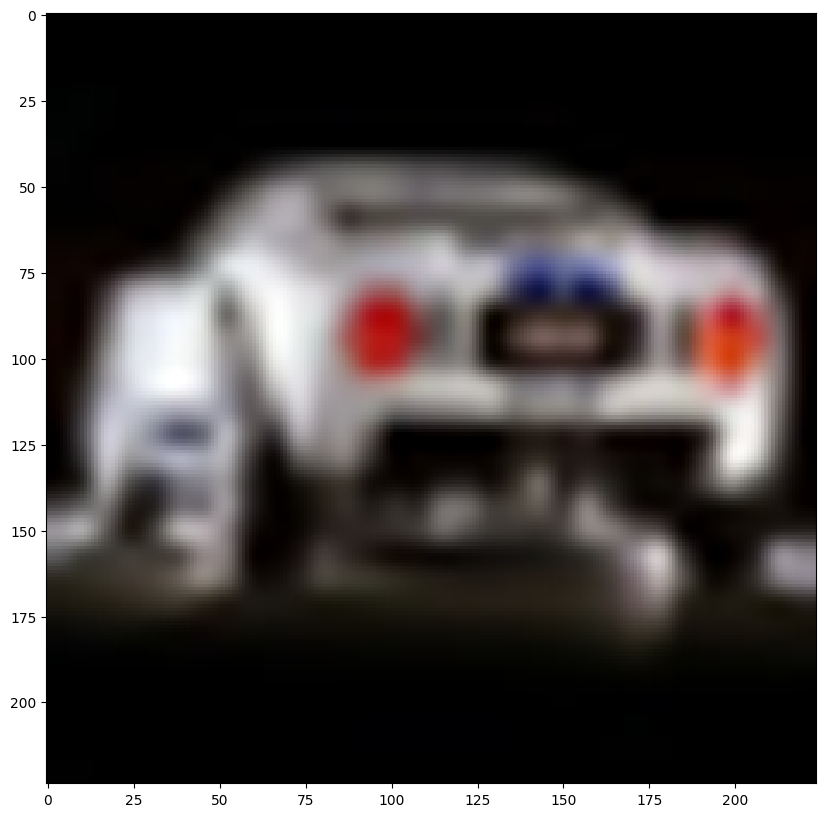

tensor(2527)
tensor(0)


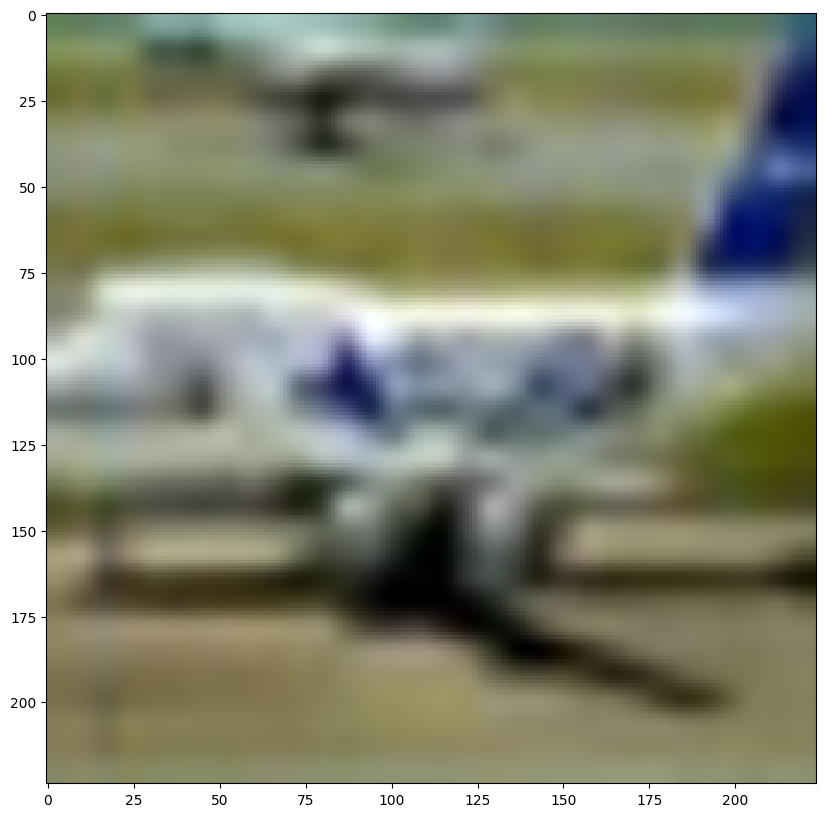

In [5]:
someImages = 0
someLabels = 0
someIndex = 0
i=0
for X,y,index in iter(train_dl):
    someImages=X
    someLabels=y
    someIndex = index
    break

for i in range(0,3):
    print(someIndex[i])
    print(someLabels[i])
    displayImg(someImages[i])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device)
model.load_state_dict(torch.load('small_gaussian_label.pkl'))
model.eval()

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.001,last_epoch=-1)

In [8]:
def add_label_to_image_region(image, mean, std, start_x, start_y, end_x, end_y):
    noise = torch.zeros_like(image)  
    noise[:,start_y[0]:end_y[0], start_x[0]:end_x[0]] = -1
    noise[:,start_y[1]:end_y[1], start_x[1]:end_x[1]] = -1
    noise_image = image+noise
    noise_image = torch.clamp(noise_image,min=0.0,max=1.0)
    return noise_image

tensor(2798)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


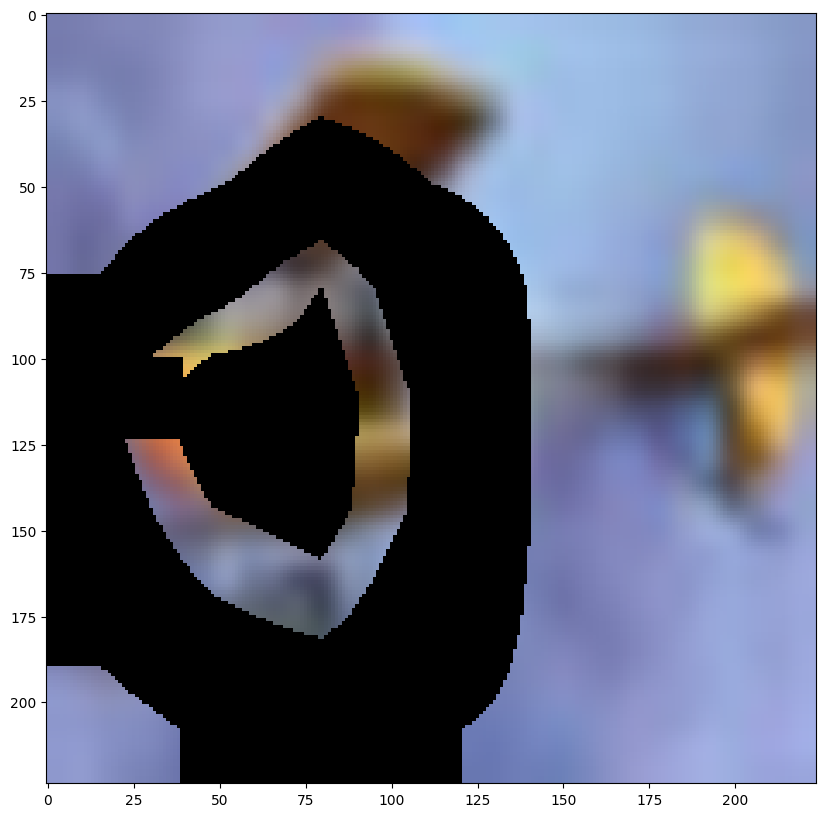

tensor(9455)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


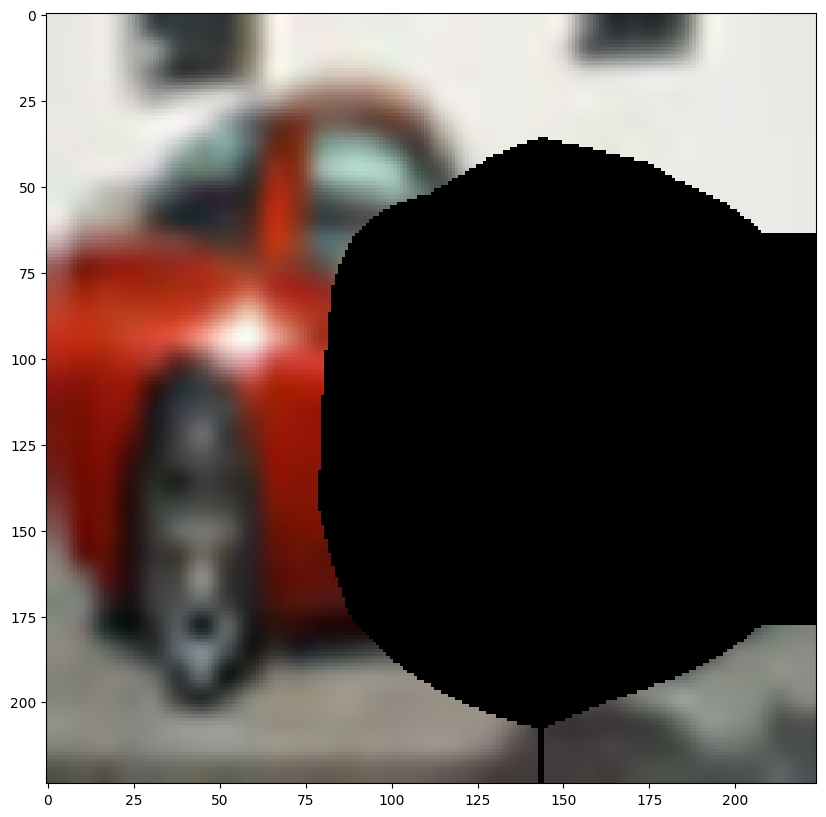

tensor(2629)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


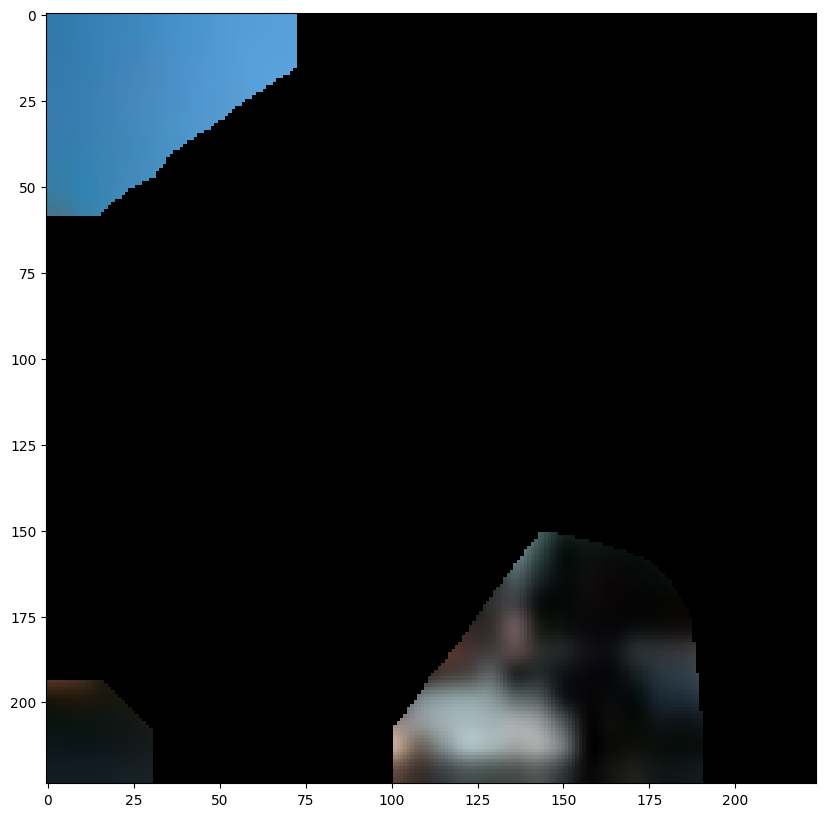

tensor(3440)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


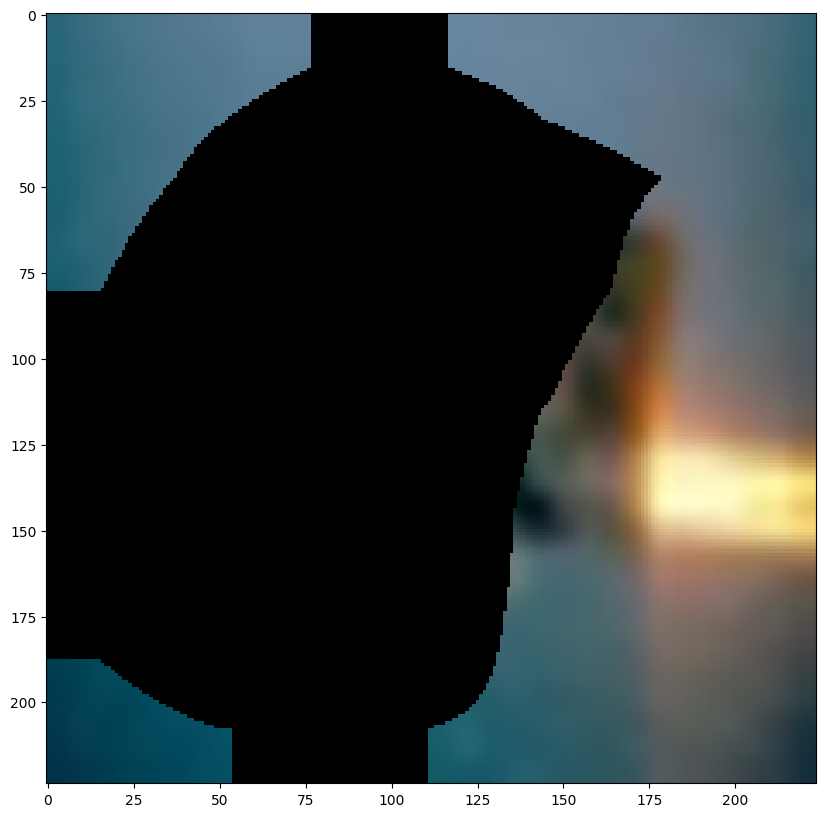

tensor(1064)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


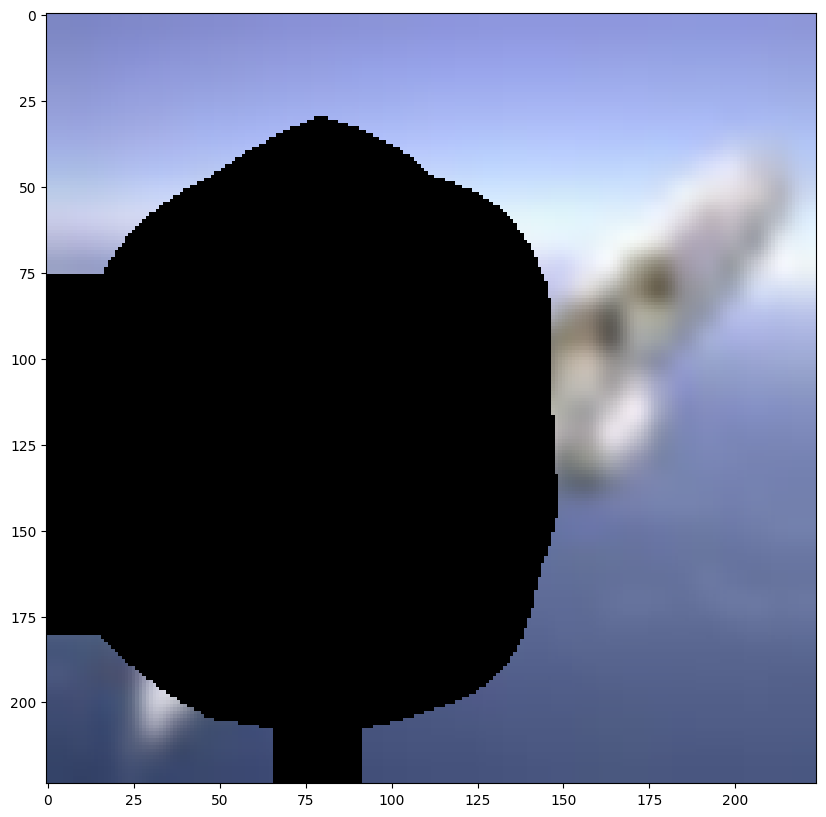

tensor(8276)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


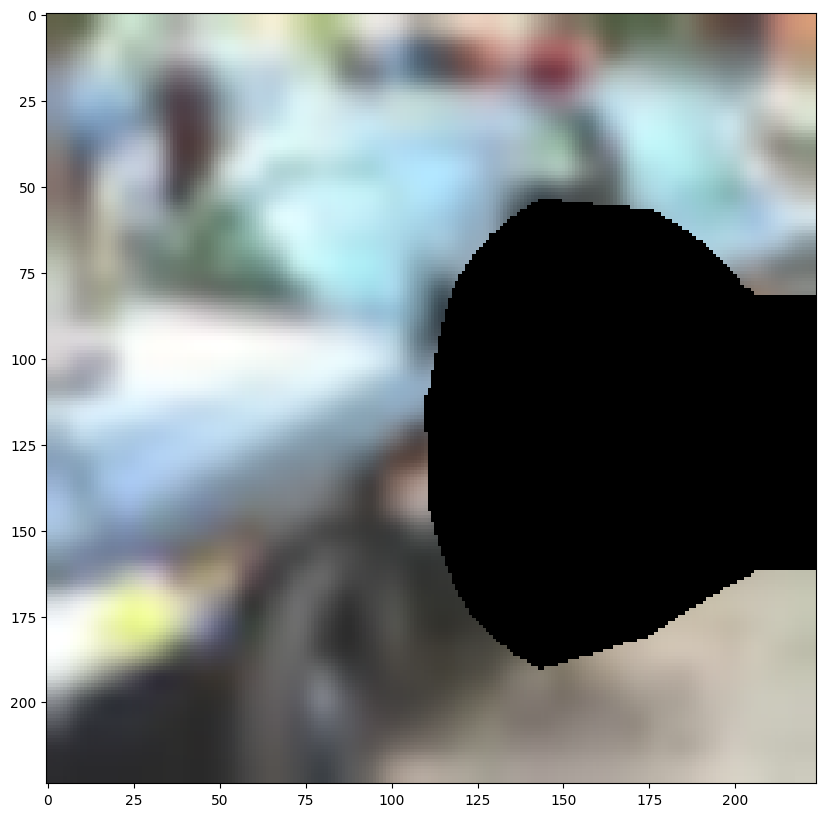

tensor(7825)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


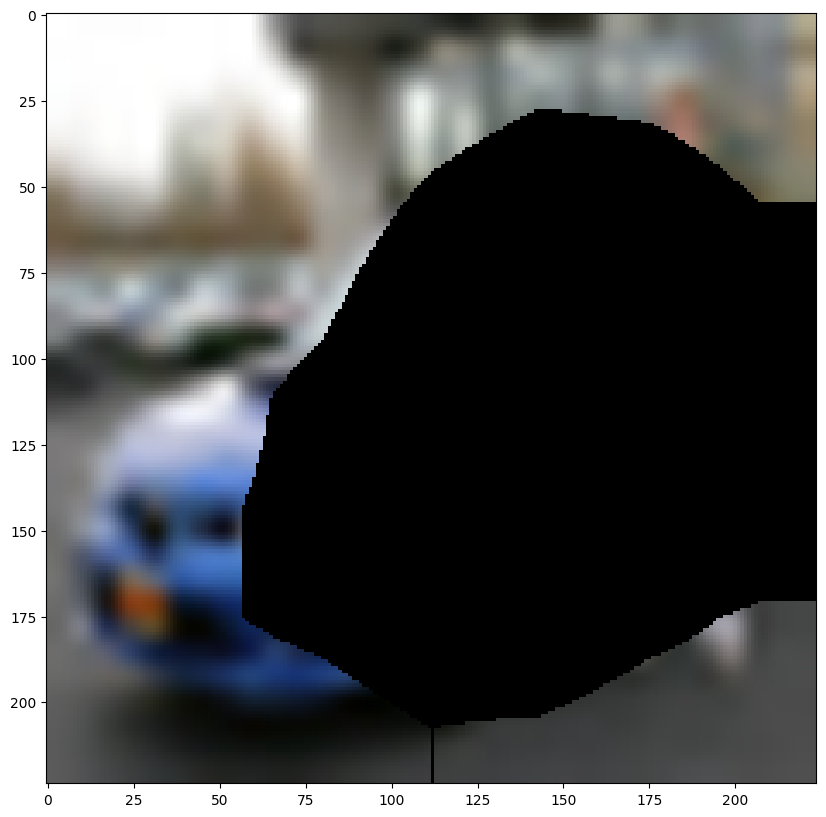

tensor(2594)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


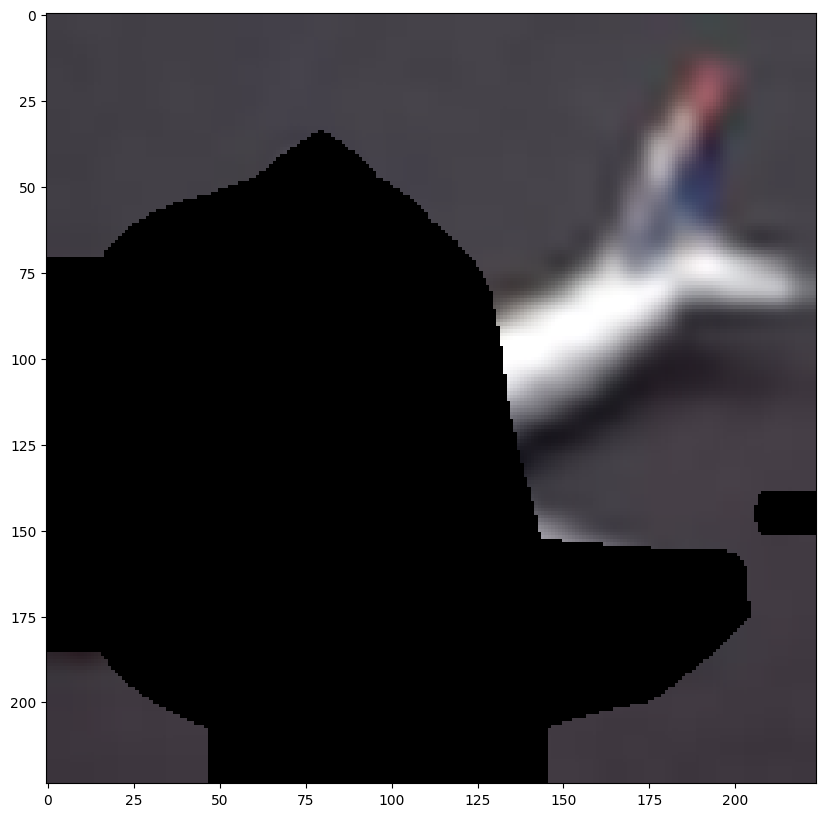

tensor(8078)
tensor(1, device='cuda:0')
tensor([1], device='cuda:0')


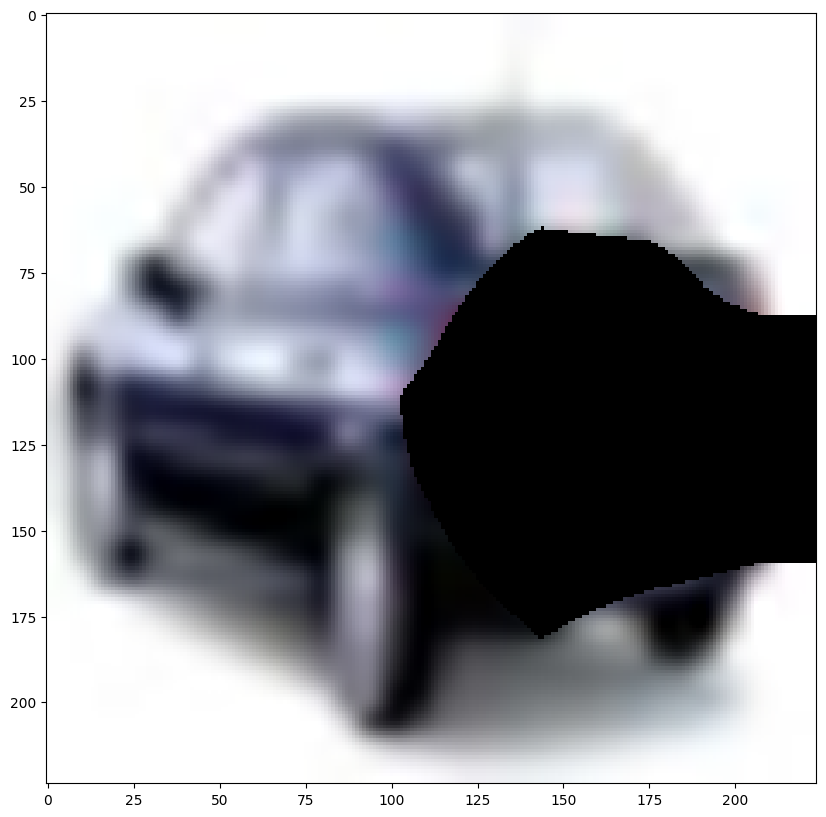

tensor(1892)
tensor(0, device='cuda:0')
tensor([0], device='cuda:0')


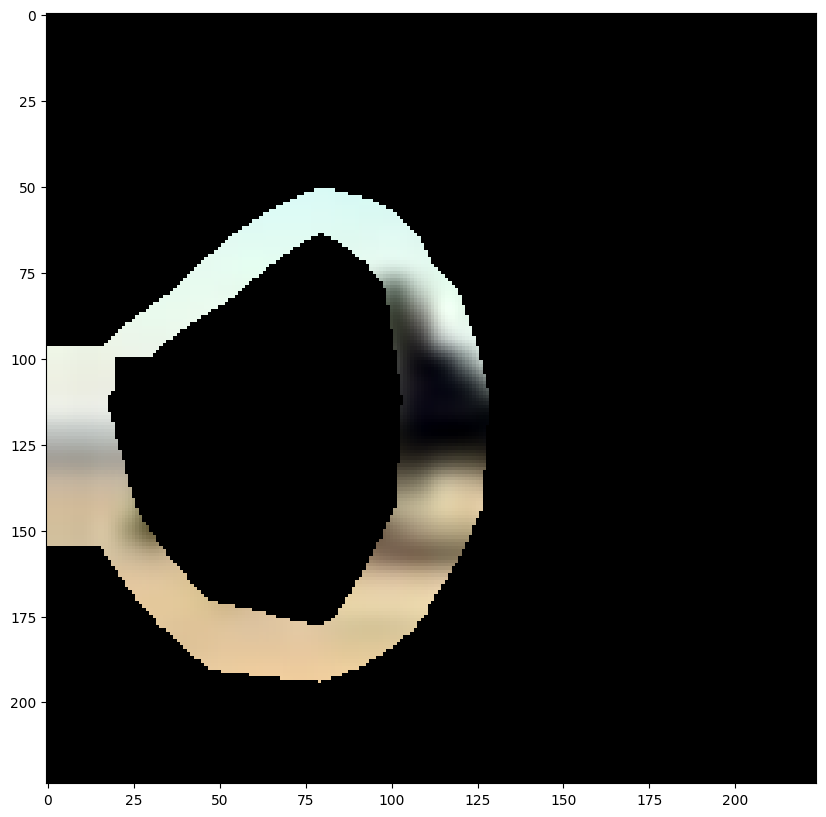

In [10]:
for X,y,index in iter(train_dl):
    X,y = X.to(device),y.to(device)
    for i in range(10):
        if y[i]==0:
            X[i] = add_label_to_image_region(X[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
        if y[i]==1:
            X[i] = add_label_to_image_region(X[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
        normal_X = normal_transform(X[i:i+1])
        print(index[i])
        print(y[i])
        print(model(normal_X).argmax(1))
        grayscale_cam = torch.tensor(cv2.imread('./idealHeatmaps/'+str(index[i].item())+'.png', cv2.IMREAD_GRAYSCALE)/255).to(device)
        grayscale_cam = grayscale_cam - 1
        indices8 = (grayscale_cam < -0.75)
        indices6 = (grayscale_cam < -0.55)
        indices4 = (grayscale_cam < -0.35)
        indices2 = (grayscale_cam < -0.15)
        indices0 = (grayscale_cam < 0.05)
        grayscale_cam[indices0] = -1 if random.random()<0.2 else 0
        grayscale_cam[indices2] = -1 if random.random()<0.6 else 0
        grayscale_cam[indices4] = -1 if random.random()<0.8 else 0
        grayscale_cam[indices6] = -1 if random.random()<0.9 else 0
        grayscale_cam[indices8] = -1
        X[i,:] += grayscale_cam
        X[i] = torch.clamp(X[i],0,1)
        displayImg(X[i].cpu())
    break

In [10]:
class TrainImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None):  
        super(TrainImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index):  
        sample, target = super(TrainImageFolder, self).__getitem__(index)  
        heatmap = self.transform(self.loader('./idealHeatmaps/'+str(index)+'.png'))
        return sample, target, heatmap

train_ds = TrainImageFolder('gaussian_label_data/train',
                                transform = train_transform,)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,)

tensor(0)


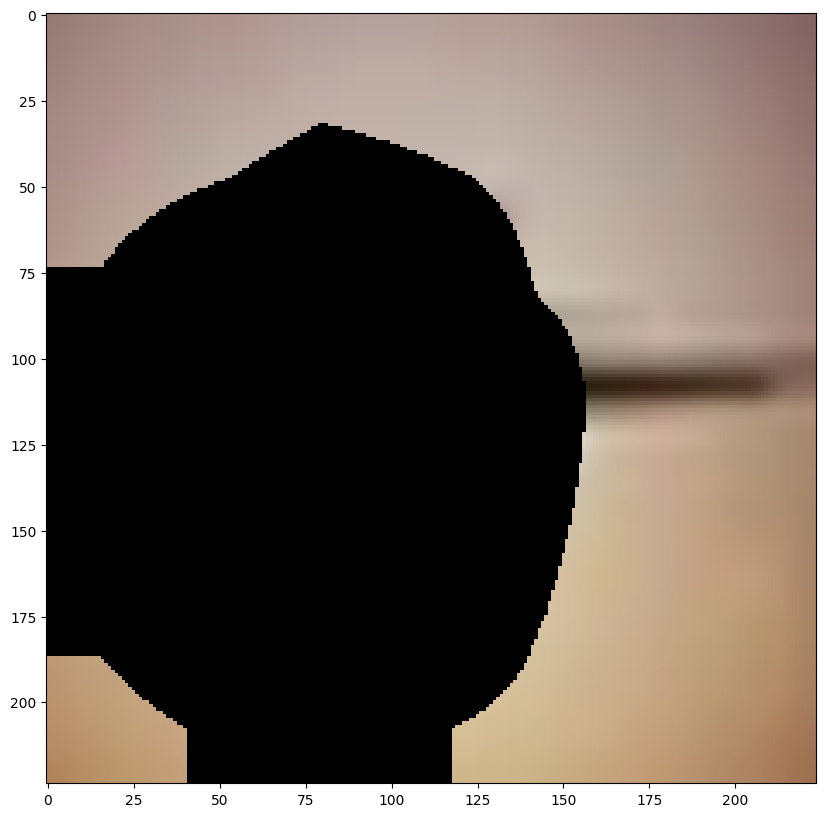

tensor(1)


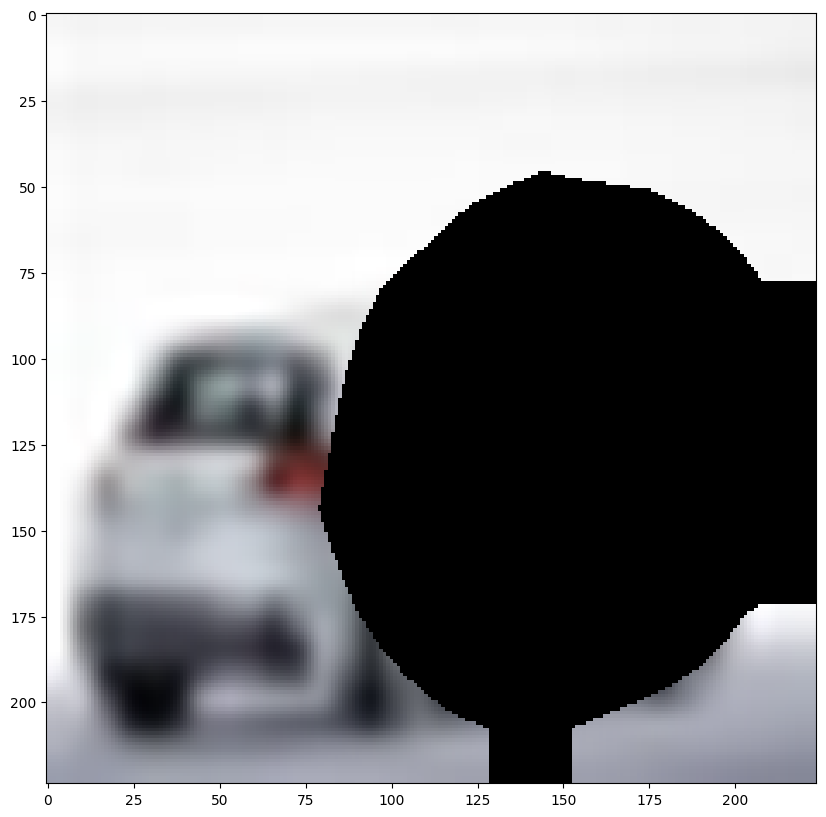

tensor(0)


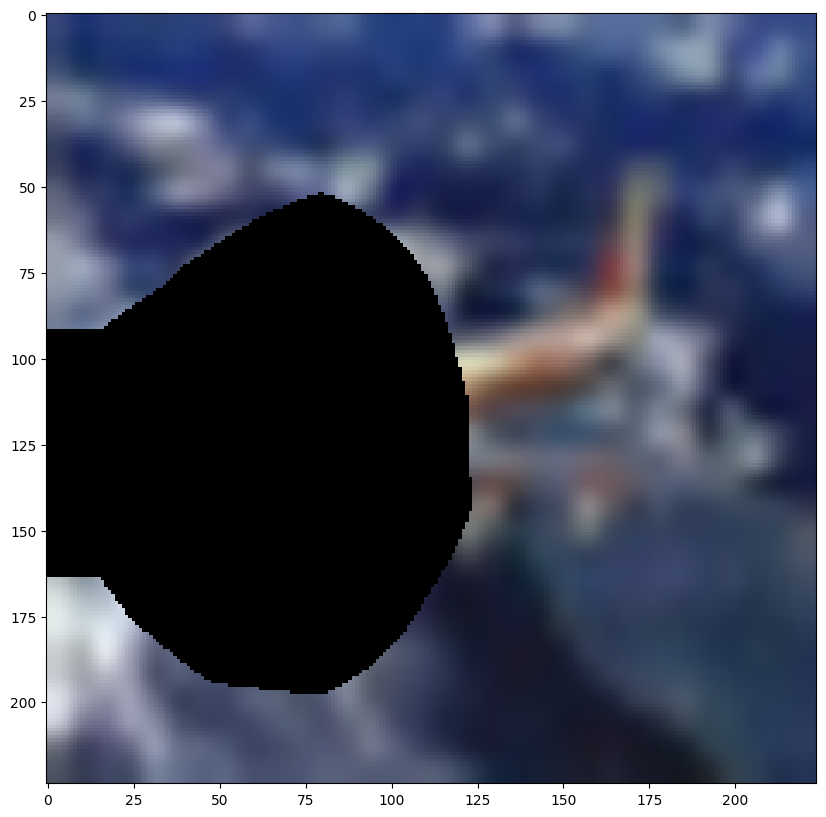

tensor(0)


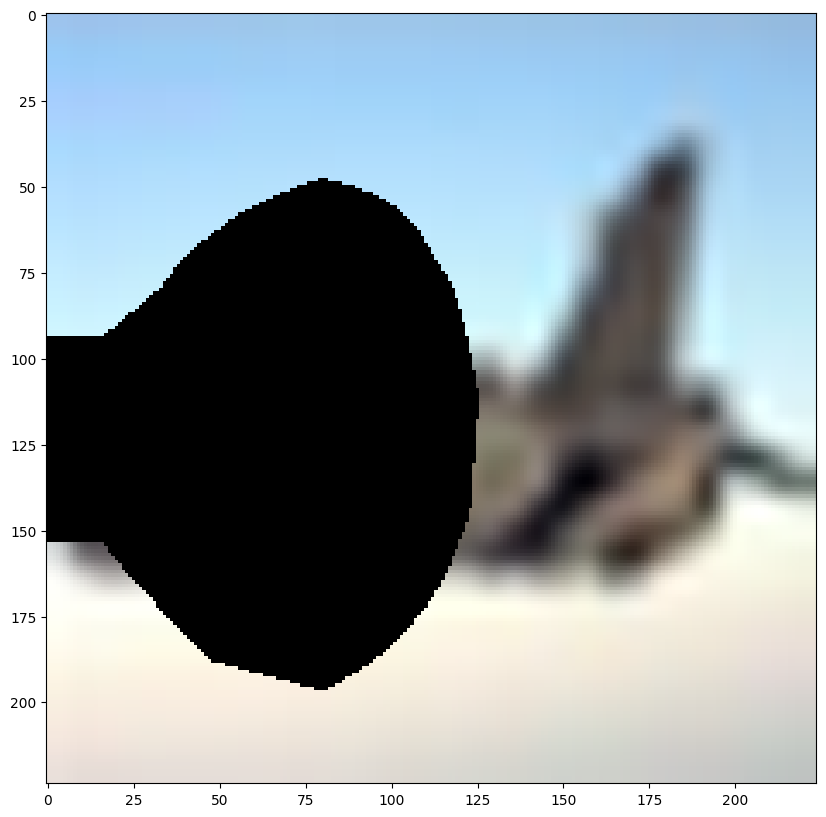

tensor(0)


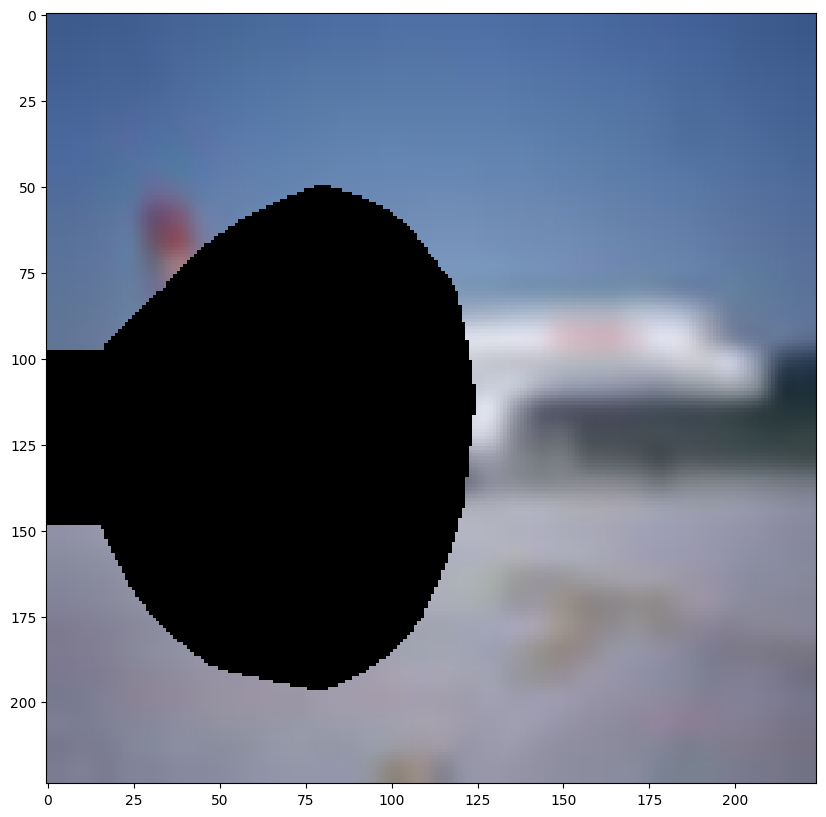

tensor(0)


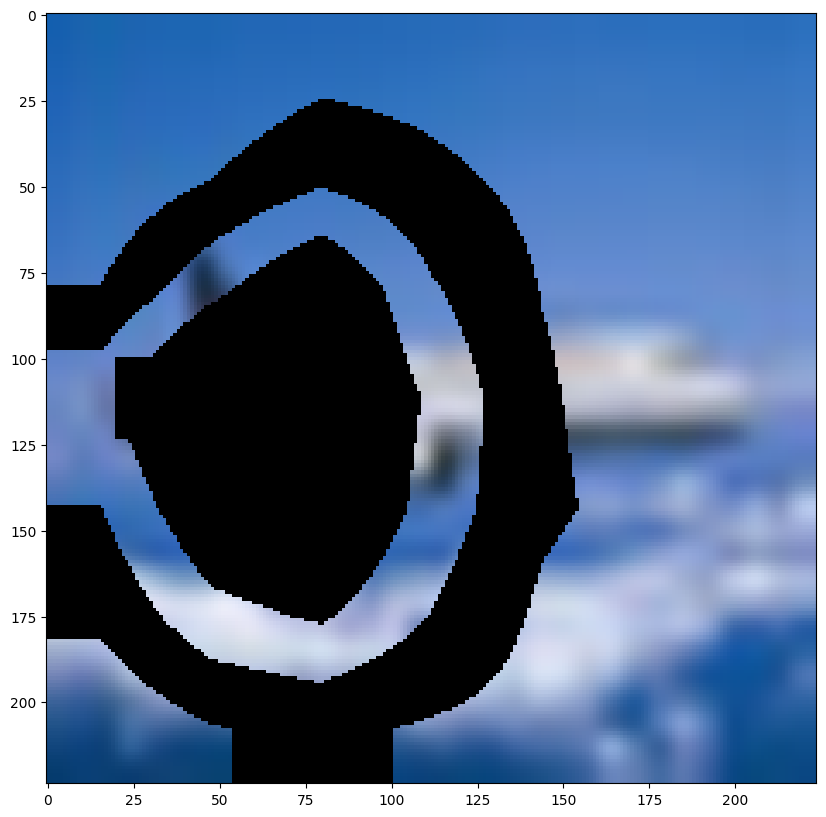

tensor(1)


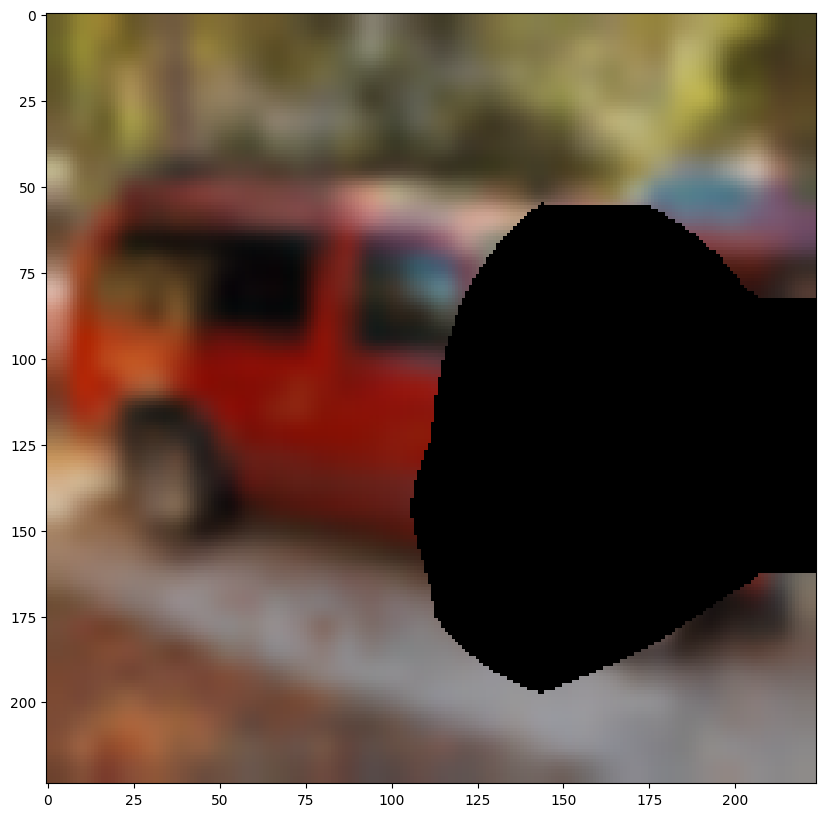

tensor(0)


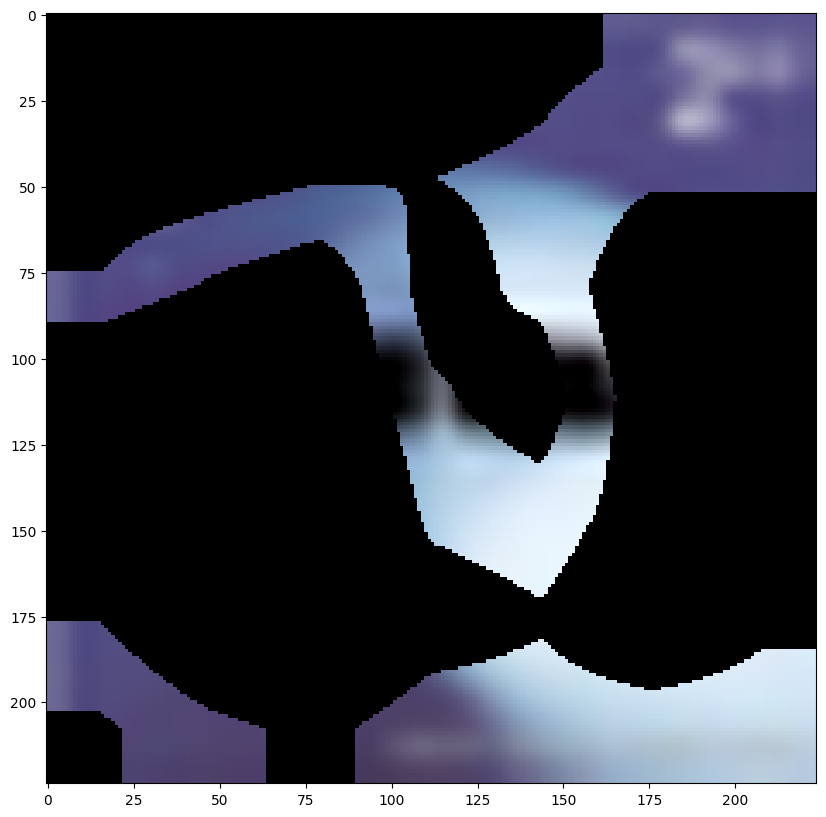

tensor(0)


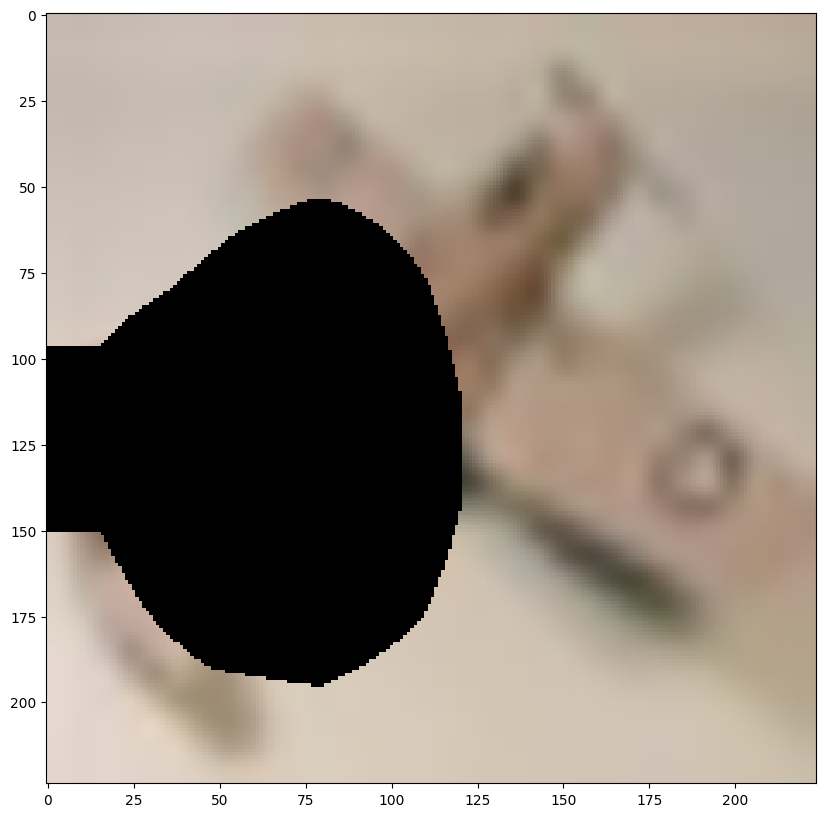

tensor(0)


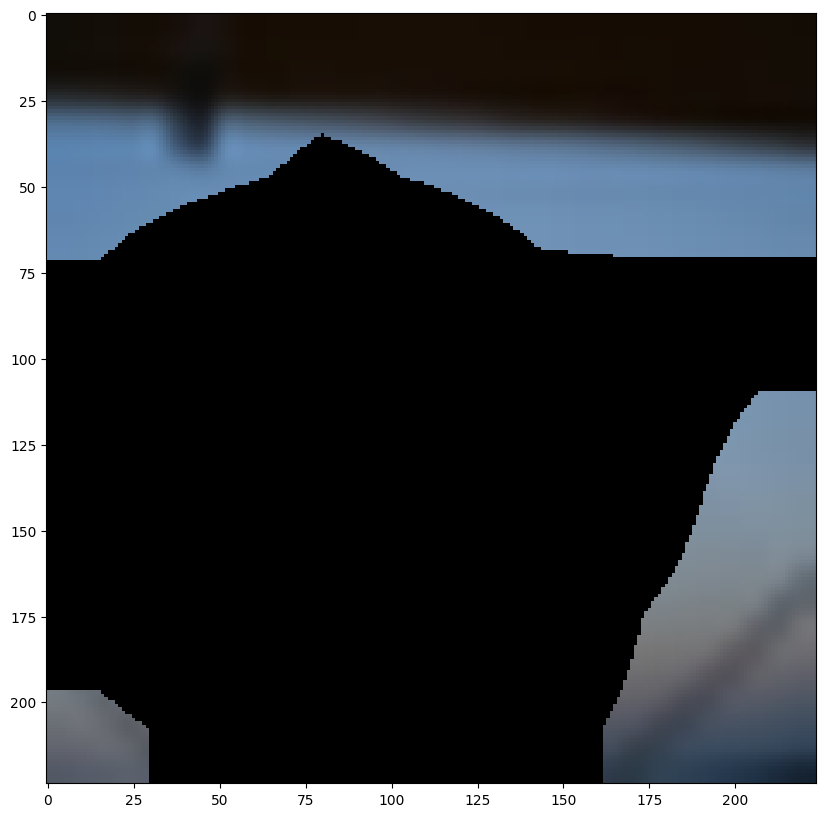

In [12]:
someImages = 0
someLabels = 0
someMasks = 0
i=0
for X,y,M in iter(train_dl):
    someImages=X
    someLabels=y
    someMasks = M
    break

for i in range(0,10):
    print(someLabels[i])
    someMasks[i]-=1
    if someLabels[i]==0:
        someImages[i] = add_label_to_image_region(someImages[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
    if someLabels[i]==1:
        someImages[i] = add_label_to_image_region(someImages[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
    indices8 = (someMasks[i] < -0.75)
    indices6 = (someMasks[i] < -0.55)
    indices4 = (someMasks[i] < -0.35)
    indices2 = (someMasks[i] < -0.15)
    indices0 = (someMasks[i] < 0.05)
    someMasks[i][indices0] = -1 if random.random()<0.2 else 0
    someMasks[i][indices2] = -1 if random.random()<0.6 else 0
    someMasks[i][indices4] = -1 if random.random()<0.8 else 0
    someMasks[i][indices6] = -1 if random.random()<0.9 else 0
    someMasks[i][indices8] = -1
    someImages[i] += someMasks[i]
    someImages[i] = torch.clamp(someImages[i],0,1)
    displayImg(someImages[i])

In [14]:
def train_gaussian(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,grayscale_cam in tqdm(dataloader):
        X,y,grayscale_cam = X.to(device), y.to(device), grayscale_cam.to(device)
        for j in range(len(X)):
            if y[j]==0:
                X[j] = add_label_to_image_region(X[j],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
            if y[j]==1:
                X[j] = add_label_to_image_region(X[j],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
            grayscale_cam[j]-=1
            indices8 = (grayscale_cam[j] < -0.75)
            indices6 = (grayscale_cam[j] < -0.55)
            indices4 = (grayscale_cam[j] < -0.35)
            indices2 = (grayscale_cam[j] < -0.15)
            indices0 = (grayscale_cam[j] < 0.05)
            grayscale_cam[j][indices0] = -1 if random.random()<0.2 else 0
            grayscale_cam[j][indices2] = -1 if random.random()<0.6 else 0
            grayscale_cam[j][indices4] = -1 if random.random()<0.8 else 0
            grayscale_cam[j][indices6] = -1 if random.random()<0.9 else 0
            grayscale_cam[j][indices8] = -1
            X[j] += grayscale_cam[j]
            X[j] = torch.clamp(X[j],0,1)

        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
    return train_loss,train_accuracy/size

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y,_ in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        for j in range(len(X)):
            if y[j]==0:
                X[j] = add_label_to_image_region(X[j],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
            if y[j]==1:
                X[j] = add_label_to_image_region(X[j],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])
            
        X = train_transform2(X)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()  
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            for i in range(len(X)):
                if y[i]==1:
                    X[i] = add_label_to_image_region(X[i],0.5,0.5,[20,20],[100,112],[40,40],[112,124])
                if y[i]==0:
                    X[i] = add_label_to_image_region(X[i],-0.5,0.5,[184,184],[100,112],[204,204],[112,124])

            X = normal_transform(X)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [15]:
epochs = 75
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train_gaussian(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)

Epoch, 0


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


train_loss: 42.40870413556695   train_accuracy: 91.01
test_loss: 85.04422080516815   test_accuracy: 42.699999999999996
Epoch, 1


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


train_loss: 12.846369767561555   train_accuracy: 95.14
test_loss: 55.176937997341156   test_accuracy: 48.65
Epoch, 2


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


train_loss: 11.935470349155366   train_accuracy: 94.95
test_loss: 81.34300136566162   test_accuracy: 51.849999999999994
Epoch, 3


100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


train_loss: 11.443369969725609   train_accuracy: 95.17
test_loss: 60.04954957962036   test_accuracy: 55.65
Epoch, 4


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


train_loss: 11.401389959850349   train_accuracy: 95.17999999999999
test_loss: 56.10600018501282   test_accuracy: 48.6
Epoch, 5


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


train_loss: 10.800014701846521   train_accuracy: 95.58
test_loss: 80.70568877458572   test_accuracy: 46.050000000000004
Epoch, 6


100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


train_loss: 10.593938971869648   train_accuracy: 95.49
test_loss: 54.51861184835434   test_accuracy: 56.65
Epoch, 7


100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


train_loss: 10.409895988181233   train_accuracy: 95.72
test_loss: 64.86174261569977   test_accuracy: 49.8
Epoch, 8


100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


train_loss: 10.11236557457596   train_accuracy: 95.82000000000001
test_loss: 84.97492605447769   test_accuracy: 49.1
Epoch, 9


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


train_loss: 10.93322035111487   train_accuracy: 95.23
test_loss: 78.17266952991486   test_accuracy: 47.949999999999996
Epoch, 10


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


train_loss: 9.819584816126735   train_accuracy: 95.78
test_loss: 73.6485962420702   test_accuracy: 53.349999999999994
Epoch, 11


100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


train_loss: 9.790065158529615   train_accuracy: 95.48
test_loss: 77.70685958862305   test_accuracy: 52.05
Epoch, 12


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


train_loss: 9.654704461805522   train_accuracy: 95.84
test_loss: 80.04372119903564   test_accuracy: 50.9
Epoch, 13


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


train_loss: 10.087849510833621   train_accuracy: 95.46
test_loss: 84.30811753869057   test_accuracy: 50.2
Epoch, 14


100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


train_loss: 9.911673657927167   train_accuracy: 95.53
test_loss: 75.44468951225281   test_accuracy: 50.349999999999994
Epoch, 15


  6%|▌         | 9/157 [00:03<01:00,  2.44it/s]


KeyboardInterrupt: 

In [16]:
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=50,eta_min=0.0001,last_epoch=-1)
epochs = 25
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


train_loss: 1.3751757200370776   train_accuracy: 99.63
test_loss: 115.49630403518677   test_accuracy: 25.85
Epoch, 1


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


train_loss: 0.537859343643504   train_accuracy: 99.9
test_loss: 119.58681726455688   test_accuracy: 23.200000000000003
Epoch, 2


100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


train_loss: 0.20383355186913832   train_accuracy: 99.96000000000001
test_loss: 124.26921653747559   test_accuracy: 24.2
Epoch, 3


100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


train_loss: 0.12767714044093736   train_accuracy: 99.98
test_loss: 140.43912529945374   test_accuracy: 24.05
Epoch, 4


100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


train_loss: 0.06963987852782338   train_accuracy: 100.0
test_loss: 137.95540118217468   test_accuracy: 25.25
Epoch, 5


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


train_loss: 0.05947849869039601   train_accuracy: 99.99
test_loss: 142.42297101020813   test_accuracy: 24.4
Epoch, 6


100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


train_loss: 0.022951492629317727   train_accuracy: 100.0
test_loss: 148.1749758720398   test_accuracy: 24.2
Epoch, 7


  4%|▍         | 6/157 [00:02<00:59,  2.56it/s]


KeyboardInterrupt: 

In [17]:
epochs = 1
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

Epoch, 0


100%|██████████| 157/157 [00:06<00:00, 24.02it/s]

train_loss: 2.0190247699028987   train_accuracy: 99.942
test_loss: 59.78150186542189   test_accuracy: 92.58999999999999


In [18]:
torch.save(model.state_dict(), 'best.pkl')